In [1]:
from RooPandasFunctions import PSequential,PColumn,PFilter,PRow,PProcessor,PProcRunner,PInitDir
import pandas as pd
from glob import glob
import ROOT
from ROOT import TH1F,TH2F,TLorentzVector,TFile,TCanvas,TLegend,gPad
from collections import OrderedDict
import numpy as np
import copy
import pyarrow as pa
import array
from optparse import OptionParser
import subprocess,os,sys
import time


Welcome to JupyROOT 6.22/00


In [2]:
#parser = OptionParser()
#
#parser.add_option('-p', '--nproc', metavar='F', type='string', action='store',
#                  default	=	'6',
#                  dest		=	'nproc',
#                  help		=	'nproc')
#
#parser.add_option('-n', '--njet', metavar='F', type='string', action='store',
#                  default	=	'3',
#                  dest		=	'njet',
#                  help		=	'njet')
#
#parser.add_option('-m', '--massrange', metavar='F', type='string', action='store',
#                  default	=	'0',
#                  dest		=	'massrange',
#                  help		=	'0,1,2,3,all')
#
#parser.add_option('-a', '--aeval', metavar='F', type='string', action='store',
#                  default	=	'95',
#                  dest		=	'aeval',
#                  help		=	'90,95,99')
#
#(options, args) = parser.parse_args()
#op_nproc=int(options.nproc)
#op_njet=int(options.njet)
#op_massrange=options.massrange
#op_aeval=options.aeval

In [3]:
op_nproc=int(6)
op_njet=int(3)
op_massrange="all"
op_aeval="90"
ntoys=0
quickrun=False
if quickrun:
    op_nproc=1

In [4]:
ROOT.gROOT.SetBatch(True)
ROOT.PyConfig.IgnoreCommandLineOptions = True

In [5]:
#this creates histos and  weights before any selection
class PreColumn():
    def __call__(self,df,EventInfo):
        EventInfo.eventcontainer["evweight"] = EventInfo.eventcontainer["lumi"]*EventInfo.eventcontainer["xsec"][EventInfo.dataset]/EventInfo.eventcontainer["nev"][EventInfo.dataset]
        df["Hists"]["logMSE_all"] = np.log(df["FatJet"]["iAEMSE"])

        df["Hists"]["weight"] *= EventInfo.eventcontainer["evweight"]
        #meh, should be added to  columnweights -- todo
        df["Hists"]["logMSE_all__weight"] = pd.Series(EventInfo.eventcontainer["evweight"], df["Hists"]["logMSE_all"].index, name="logMSE_all__weight")
        return df

In [6]:
#Select jetwise and eventwise. Exactly 4 jets with pt in region X, and all have sdmass in region Y
class KinematicSelection():
    def __init__(self,njet,ptcut,msdcut):
        self.ptcut=ptcut
        self.njet=njet
        self.msdcut=msdcut
    def __call__(self,df,EventInfo):
        
        fjcutpt=(df["FatJet"]["pt"]>self.ptcut[0]) &(df["FatJet"]["pt"]<self.ptcut[1]) 
        df["FatJet"]=df["FatJet"][fjcutpt]
        C1=(df["FatJet"]["event"].count(level=0))==self.njet

        fjcutmass=(df["FatJet"]["msoftdrop"]>self.msdcut[0])&(df["FatJet"]["msoftdrop"]<self.msdcut[1])
        df["FatJet"]=df["FatJet"][fjcutmass]

        C2=(df["FatJet"]["event"].count(level=0))==self.njet

        fjcut=fjcutpt&fjcutmass
        C0=((fjcut).sum(level=0)>0)
   

        if (not ( C0 & C1 & C2).any()):
            return None
        return ( C0 & C1 & C2)

In [7]:
#Select DeltaR cut to make sure AK8 jets are separated
class KinematicSelectionDR():
    def __init__(self,njet,drcut):
        self.drcut=drcut
        self.njet=njet
    def __call__(self,df,EventInfo):    
        alldiscs=[]

        for ijet in range(self.njet):
            #todo: find better way to check for nulls
            try:
                ijetphi=df["FatJet"]["phi"][:,ijet]
                ijeteta=df["FatJet"]["eta"][:,ijet]
            except:
                print ("ERR")
                print (df["FatJet"]["phi"])
                print (df["FatJet"]["eta"])
                return None

            drcutjet=None
            for jjet in range(self.njet):

                if ijet==jjet:
                    continue
            
                jjetphi=df["FatJet"]["phi"][:,jjet]
                jjeteta=df["FatJet"]["eta"][:,jjet]

                deta=(jjeteta-ijeteta).abs()
                dphi=(jjetphi-ijetphi).abs()

                dphi[dphi>3.1415]=2*3.1415-dphi

                dr=np.sqrt(dphi*dphi+deta*deta)
                curcond=dr>self.drcut
                #print(curcond)
                if isinstance(drcutjet,type(None)):
                    drcutjet=curcond
                else:
                    drcutjet=drcutjet&(curcond)

            alldiscs.append(drcutjet)

        for iad,ad in enumerate(alldiscs):
            if iad==0:
                evdisc=ad
            else:
                evdisc=evdisc&ad
        #print("evd",evdisc)

        return ( evdisc )

In [8]:
#Create tight and loose jet tags
class MakeTags():
    def __init__(self,njet):
        self.njet=njet
    def __call__(self,df,EventInfo):


        cut90,cut95,cut99=-11.28,-10.74,-9.9
        logmse=np.log(df["FatJet"]["iAEMSE"])
        
        if op_aeval=="90":
            AEcut=cut90
        elif op_aeval=="95":
            AEcut=cut95
        elif op_aeval=="99":
            AEcut=cut99
        else:
            raise ValueError("Bad AE cut")

        njettight=((logmse>AEcut).sum(level=0))
        njetloose=((logmse<AEcut).sum(level=0))

        df["FatJet"]["tight"] = logmse>AEcut
        df["FatJet"]["loose"] = logmse<AEcut

        df["Hists"]["ht"]=df["FatJet"]["pt"].sum(level=0)
        df["Hists"]["njettight"] = njettight
        df["Hists"]["njetloose"] = njetloose

        return df

In [9]:
#project weights
class ColumnWeights():
    def __call__(self,df,EventInfo):
        keys=list(df["Hists"].keys())
        for hh in keys:
            if hh in ["njettight__njetloose","event","weight"]:
                continue
            if hh+"__weight" in df["Hists"]:
                continue
            df["Hists"][hh+"__weight"]=df["Hists"]["weight"]
            if (df["Hists"][hh].index.nlevels > df["Hists"]["weight"].index.nlevels )  :
                df["Hists"][hh]=df["Hists"][hh].droplevel(level=1)

            df["Hists"][hh+"__weight"] = df["Hists"][hh+"__weight"][df["Hists"][hh+"__weight"].index.isin(df["Hists"][hh].index)]
         

        df["Hists"]["njettight__njetloose__weight"]=df["Hists"]["njettight__weight"]
        return df

In [10]:
#make histograms to be used for creating the pass-to-fail ratio
class MakeHistsForBkg():
    def __init__(self,njet):
        self.njet=njet
    def __call__(self,df,EventInfo):
        bkgparam=EventInfo.eventcontainer["bkgparam"]
        for ijet in range(self.njet):
            for ebin in bkgparam["eta"]:
                #tightreq=(df["Hists"]["njettight"]==1) | (df["Hists"]["njettight"]==0)
                tightreq=True
                abseta=df["FatJet"]["eta"].abs()

                etacut=(bkgparam["eta"][ebin][0]<=abseta)&(abseta<bkgparam["eta"][ebin][1])

                try:
                    df["Hists"]["ptT"+str(ijet)+"_"+ebin]=df["FatJet"]["pt"][df["FatJet"]["tight"]][etacut][:,ijet]
                except:
                    print("Fail ptT")
                    pass
                try:
                    df["Hists"]["ptL"+str(ijet)+"_"+ebin]=df["FatJet"]["pt"][df["FatJet"]["loose"]][etacut][:,ijet]
                except:
                    print("Fail ptL")
                    pass
            
            regionstr="LT"+str(ijet)+str(njet-ijet)
            df["Hists"]["ht_"+regionstr]=df["Hists"]["ht"][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]
            
            for jjet in range(njet):
                df["Hists"]["pt"+str(jjet)+"_"+regionstr]=df["FatJet"]["pt"][:,jjet][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]
                df["Hists"]["ptTIGHT"+str(jjet)+"_"+regionstr]=df["FatJet"]["pt"][df["FatJet"]["tight"]][:,jjet][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]
                df["Hists"]["ptLOOSE"+str(jjet)+"_"+regionstr]=df["FatJet"]["pt"][df["FatJet"]["loose"]][:,jjet][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]     
        return df

In [11]:
#use pass-to-fail ratio created in step0 to predict background
#todo: Sometimes returns none -- look into
class BkgEst():
    
    def __init__(self,njet):
        self.njet=njet
    
    def prepdf(self,df):
        args=[df["Hists"]["ht"]]
        try:
            for ijet in range(self.njet):
                args.append(df["FatJet"]["pt"][:,ijet])
                args.append(df["FatJet"]["eta"][:,ijet].abs())
                args.append(df["FatJet"]["tight"][:,ijet])
                args.append(df["FatJet"]["loose"][:,ijet])
        except Exception as e:
            print (e)
            return None
        return args
    
    def __call__(self,args,EventInfo):
        
        bkgparam=EventInfo.eventcontainer["bkgparam"]
        RateHists=EventInfo.eventcontainer["RateHists"]
        ht=args[0]
        pt=[]
        eta=[]
        tight=[]
        loose=[]
        ptTIGHT=[]
        ptLOOSE=[]
        
        for ijet in range(self.njet):
            pt.append(args[ijet*4+1])
            eta.append(args[ijet*4+2])
            tight.append(args[ijet*4+3])
            loose.append(args[ijet*4+4])
            
            regionstr="LT"+str(ijet)+str(njet-ijet)
        
        nloose=0
        for ll in loose:
            nloose+=ll
        ntight=0
        for tt in tight:
            ntight+=tt
        
        #if ((nloose)==self.njet):
        
        maxbin=2**self.njet
        allregs=list(range(maxbin))
        allregs.reverse()
        Trate=[]
        Lrate=[]
        Trateup=[]
        Lrateup=[]   
        Tratedown=[]
        Lratedown=[] 
        jetebin=[] 
        jetptbin=[] 

        
        
        for ijet in range(self.njet):
            for iebin,ebin in enumerate(bkgparam["eta"]):

            


                etacut=(bkgparam["eta"][ebin][0]<=eta[ijet]<bkgparam["eta"][ebin][1])
                
                if etacut:
                    ptbin=RateHists["Rate"+ebin].FindBin(pt[ijet])
                    TRtemp=RateHists["Rate"+ebin].GetBinContent(ptbin)
                    TRtemperr=RateHists["Rate"+ebin].GetBinError(ptbin)
                    Trate.append(TRtemp)
                    Lrate.append(1.0-TRtemp)
                    
                    jetebin.append(iebin)
                    jetptbin.append(ptbin)                  
                    
                    
        weights=[0.0]*(self.njet+1)
        weightsT=[ [0.0]*(self.njet+1) for _ in range(self.njet) ]
        weightsL=[ [0.0]*(self.njet+1) for _ in range(self.njet) ]
        nweights=[0.0]*(self.njet+1)
        
        for ar in allregs:
            ntight=0
            weight=1.0
            weightT=[ 1.0 ]*(self.njet)
            weightL=[ 1.0 ]*(self.njet)
            for ibit,bit in enumerate(range(self.njet)):
            
                curbit=(ar>>bit)&1
                ntight+=curbit
                
                if curbit:
                    weight*=Trate[ibit]   
                    for kjet in range(self.njet):
                        if ibit==kjet:
                            if tight[kjet]:
                                weightL[kjet]*=0.0 
                                weightT[kjet]*=1.0 
                            else:
                                weightL[kjet]*=0.0 #should this be 1? 
                                weightT[kjet]*=0.0                                 
                        else:
                            weightL[kjet]*=Trate[ibit] 
                            weightT[kjet]*=Trate[ibit]  
                else:
                    weight*=Lrate[ibit]
                    for kjet in range(self.njet):
                        if ibit==kjet:
                            
                            if tight[kjet]:
                                weightL[kjet]*=0.0 
                                weightT[kjet]*=0.0  #should this be 1? 
                            else:
                                weightL[kjet]*=1.0 
                                weightT[kjet]*=0.0                                
                        
                        else:
                            weightT[kjet]*=Lrate[ibit] 
                            weightL[kjet]*=Lrate[ibit]  

                    
            for kjet in range(self.njet):
                weightsT[kjet][self.njet-ntight]+=weightT[kjet]
                weightsL[kjet][self.njet-ntight]+=weightL[kjet]              
                    
                    
            weights[self.njet-ntight]+=weight
            nweights[self.njet-ntight]+=1.0
  
                
                
        allret=[]

        

        for icweight,cweight in enumerate(weights):
            allret.append(ht)
            allret.append(cweight*EventInfo.eventcontainer["evweight"])
            
            for jjet in range(njet):
                allret.append(pt[jjet])
                allret.append(cweight*EventInfo.eventcontainer["evweight"])
                
                
                allret.append(pt[jjet])
                allret.append(weightsT[jjet][icweight]*EventInfo.eventcontainer["evweight"])

                allret.append(pt[jjet])
                allret.append(weightsL[jjet][icweight]*EventInfo.eventcontainer["evweight"])
                
                #print("jetebin[jjet],jetptbin[jjet]",jetebin[jjet],jetptbin[jjet])
                allret.append(jetebin[jjet])
                allret.append(jetptbin[jjet])
                

        #print("len(allret)",len(allret),EventInfo.dataset)
        return (allret)

In [12]:
#print (returndf["QCD_HT1500to2000"]["ebin0_LT12"])
#print (returndf["QCD_HT1500to2000"]["ptbin0_LT12"])

class MakeToys():
    def __init__(self,njet):
        self.njet=njet
    def __call__(self,df,EventInfo):
        bkgparam=EventInfo.eventcontainer["bkgparam"]
                
        maxbin=2**self.njet
        allregs=list(range(maxbin))
        allregs.reverse()
        #print ("df.shape",df["Hists"]["ht"].shape)

        for ijet in range(self.njet+1):

            regionstr="LT"+str(ijet)+str(njet-ijet) 
            
            allt=EventInfo.eventcontainer["toys"]
            #print(allt.shape)

            allteval=[]
            for jjet in range(njet):
                #print(allt[df["Hists"]["ebin"+str(jjet)+"_"+regionstr]].shape)
                #print(allt[df["Hists"]["ebin"+str(jjet)+"_"+regionstr]][0].shape)
                #print(allt[df["Hists"]["ebin"+str(jjet)+"_"+regionstr]][0][0].shape)
                #print(allt[df["Hists"]["ebin"+str(jjet)+"_"+regionstr]][0][0][:].shape)
                #print(allt[df["Hists"]["ebin"+str(jjet)+"_"+regionstr]][0][0][:][df["Hists"]["ptbin"+str(jjet)+"_"+regionstr]].shape)
                #print (allt.shape)
                allteval.append(allt[df["Hists"]["ebin"+str(jjet)+"_"+regionstr],:,df["Hists"]["ptbin"+str(jjet)+"_"+regionstr]])
                #print("POST",allteval[-1].shape)
                allteval[-1]=allteval[-1].squeeze()
                #print("FINAL",allteval[-1].shape)
            for tt in range(ntoys):
                #times.append(time.time())
                sumem=np.zeros(df["Hists"]["ht"].shape)
                times=[]
                if True:

                    resampleT=[]
                    resampleL=[]
                    
                    #times.append(time.time())
                    #print("Start",times[-1]-times[0])                
                    

                    for jjet in range(njet):
                        #times.append(time.time())
                        #print("JJgo",jjet,times[-1]-times[-2])
                        
                        #print(allteval.shape)
                        #print(allteval[jjet].shape)
                        #print(allteval[jjet][:,tt].shape)

                        resampleT.append(allteval[jjet][:,tt])
                        #times.append(time.time())
                        #print("JJgo1",jjet,times[-1]-times[-2])                
                        resampleL.append(np.ones(resampleT[-1].shape))
                        #times.append(time.time())
                        #print("JJgo2",jjet,times[-1]-times[-2])                
                        resampleL[-1]=(resampleL[-1]-resampleT[-1])
                        
                        #times.append(time.time())
                        #print("JJgo3",jjet,times[-1]-times[-2])                
                    #times.append(time.time())        
                    #print("JJETend",times[-1]-times[-2])                
                
                    for ar in allregs:
                        ntight=0
                        for ibit,bit in enumerate(range(self.njet)):
                            curbit=(ar>>bit)&1
                            if curbit:
                                ntight+=1
                        if ntight!=(njet-ijet):
                            continue
                        #print(resampleT[-1].shape)
                        weight=np.ones(resampleT[-1].shape)
                        for ibit,bit in enumerate(range(self.njet)):

                            curbit=(ar>>bit)&1
                            #print("resampleT[ibit]"  )
                            #print(resampleT[ibit]  )
                            #print(resampleL[ibit]  )
                            
                            if curbit:
                                weight*=resampleT[ibit]    
                            else:
                                weight*=resampleL[ibit]  
                            #print(weight.shape)
                            #print(weight[:,0])
                           # print(weight[:,1])
                        #print(weight.shape)
                        sumem+=weight*EventInfo.eventcontainer["evweight"]
                    #times.append(time.time())
                    #print("ARend",times[-1]-times[-2])
                df["Hists"]["bkg_ht_toy"+str(tt)+"_"+regionstr+"__weight"]=pd.Series(sumem,index=df["Hists"]["ht"].index)
                #times.append(time.time())
                #print("Weightsdone",times[-1]-times[-2])
                df["Hists"]["bkg_ht_toy"+str(tt)+"_"+regionstr]=df["Hists"]["ht"]

                #print(df["Hists"]["bkg_ht_toy"+str(tt)+"_"+regionstr])
                #print(df["Hists"]["bkg_ht_toy"+str(tt)+"_"+regionstr+"__weight"])
                #print(df["Hists"]["bkg_ht_toy"+str(tt)+"_"+regionstr+"__weight"].shape)
                #print(df["Hists"]["bkg_ht_toy"+str(tt)+"_"+regionstr].shape)
        #print(df["Hists"])

        return df


In [13]:
chunklist=PInitDir("RooFlatFull")
bkgparam={}

#three eta bins (probably overkill)
bkgparam["eta"]={"E0":[0.0,0.4],"E1":[0.4,0.9],"E2":[0.9,1.3],"E3":[1.3,float("inf")]}

#todo: muon triggers a failure mode as sometimes events have no muons and no filter remo 
branchestoread={
                    #"Muon":["pt","eta","phi","mass"],
                    "FatJet":["pt","eta","phi","mass","msoftdrop","iAEMSE"],
                    "":["run","luminosityBlock","event"]
                    }

scalars=[""]

if op_massrange=="all":
    sdcut=[0.0,float("inf")]
else:
    #sdcuts=[[0.0,50.0],[50.0,100.0],[100.0,140.0],[140.0,200.0],[200.0,float("inf")]]
    sdcuts=[[0.0,50.0],[50.0,float("inf")]]
    sdcut=sdcuts[int(op_massrange)]

In [14]:
#customize a multi-step processor
def MakeProc(njet,step,evcont):
    histostemp=OrderedDict  ([])
    if step==0:
        for ijet in range(njet+1):
            regionstr="LT"+str(ijet)+str(njet-ijet)
            histostemp["ht_"+regionstr]=TH1F("ht_"+regionstr,"ht_"+regionstr,700,0,7000)

            for jjet in range(njet):
                histostemp["pt"+str(jjet)+"_"+regionstr]=TH1F("pt"+str(jjet)+"_"+regionstr,"pt"+str(jjet)+"_"+regionstr,1000,0,10000)
                histostemp["ptTIGHT"+str(jjet)+"_"+regionstr]=TH1F("ptTIGHT"+str(jjet)+"_"+regionstr,"ptTIGHT"+str(jjet)+"_"+regionstr,100,0,2000)
                histostemp["ptLOOSE"+str(jjet)+"_"+regionstr]=TH1F("ptLOOSE"+str(jjet)+"_"+regionstr,"ptLOOSE"+str(jjet)+"_"+regionstr,100,0,2000)
            
            for ebin in bkgparam["eta"]:
                    histostemp["ptL"+str(ijet)+"_"+ebin]=TH1F("ptL"+str(ijet)+"_"+ebin,"ptL"+str(ijet)+"_"+ebin,1000,0,10000)
                    histostemp["ptT"+str(ijet)+"_"+ebin]=TH1F("ptT"+str(ijet)+"_"+ebin,"ptT"+str(ijet)+"_"+ebin,1000,0,10000)

        histostemp["logMSE_all"]=TH1F("logMSE_all","logMSE_all",100,-20.,0.)
        myana=  [
                PColumn(PreColumn()),
                PFilter(KinematicSelection(njet,[200.0,float("inf")],sdcut)), 
                PFilter(KinematicSelectionDR(njet,1.4)),
                PColumn(MakeTags(njet)),
                PColumn(MakeHistsForBkg(njet)),
                PColumn(ColumnWeights()),
                ]

    if step==1:
        hpass=[]
        for ijet in range(njet+1):
            regionstr="LT"+str(ijet)+str(njet-ijet)
            
            histostemp["bkg_ht_"+regionstr]=TH1F("bkg_ht_"+regionstr,"bkg_ht_"+regionstr,700,0,7000)
            
            hpass.append(["Hists","bkg_ht_"+regionstr])
            hpass.append(["Hists","bkg_ht_"+regionstr+"__weight"])
            
            
            for jjet in range(njet):
                histostemp["bkg_pt"+str(jjet)+"_"+regionstr]=TH1F("bkg_pt"+str(jjet)+"_"+regionstr,"bkg_pt"+str(jjet)+"_"+regionstr,1000,0,10000)
                hpass.append(["Hists","bkg_pt"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_pt"+str(jjet)+"_"+regionstr+"__weight"])
                
                histostemp["bkg_ptTIGHT"+str(jjet)+"_"+regionstr]=TH1F("bkg_ptTIGHT"+str(jjet)+"_"+regionstr,"bkg_ptTIGHT"+str(jjet)+"_"+regionstr,100,0,2000)
                hpass.append(["Hists","bkg_ptTIGHT"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_ptTIGHT"+str(jjet)+"_"+regionstr+"__weight"])
            
                histostemp["bkg_ptLOOSE"+str(jjet)+"_"+regionstr]=TH1F("bkg_ptLOOSE"+str(jjet)+"_"+regionstr,"bkg_ptLOOSE"+str(jjet)+"_"+regionstr,100,0,2000)
                hpass.append(["Hists","bkg_ptLOOSE"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_ptLOOSE"+str(jjet)+"_"+regionstr+"__weight"])
                
                hpass.append(["Hists","ebin"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","ptbin"+str(jjet)+"_"+regionstr])
        

         
            for itoy in range(ntoys):
                histostemp["bkg_ht_toy"+str(itoy)+"_"+regionstr]=TH1F("bkg_ht_toy"+str(itoy)+"_"+regionstr,"bkg_ht_toy"+str(itoy)+"_"+regionstr,700,0,7000)         
        
        
        
        print("len(hpass)",len(hpass))        
                    
        myana=  [
                PColumn(PreColumn()),
                PFilter(KinematicSelection(njet,[200.0,float("inf")],sdcut)),     
                PFilter(KinematicSelectionDR(njet,1.4)),
                PColumn(MakeTags(njet)),
                PRow(hpass,BkgEst(njet)),
                #PColumn(MakeToys(njet)),
                PColumn(ColumnWeights()),
                ]
    for hist in histostemp:
        histostemp[hist].Sumw2() 


    histos= {}
    for ds in chunklist:
        if quickrun:
            chunklist[ds]=chunklist[ds][:1]
        #chunklist[ds]=chunklist[ds][:12]
        histos[ds]=copy.deepcopy(histostemp)

    return PProcessor(chunklist,histos,branchestoread,myana,eventcontainer=evcont,atype="flat",scalars=scalars)

In [15]:
njet=op_njet
evcont={"lumi":(1000.0*137.65),"xsec":{"WgWg":1.0,"TT":1.0,"QCD_HT1500to2000":101.8,"QCD_HT1000to1500":1005.0,"QCD_HT2000toInf":20.54},"nev":{"WgWg":18000.0,"TT":305963.0,"QCD_HT1500to2000":10655313.0,"QCD_HT1000to1500":12660521.0,"QCD_HT2000toInf":4980828.0}}
evcont["bkgparam"]=bkgparam

In [16]:
#Step0:make hists for pass-to-fail ratio
proc = MakeProc(njet,0,evcont)
nproc=op_nproc
Mproc=PProcRunner(proc,nproc)
returndf=Mproc.Run()

Running process over 6 processors


Dataset:QCD_HT2000toInf Process:1: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]]


{'TT': ({}, {'Start': 6541389928.449209, 'File Read': 6541389928.621198, 'Parsed': 6541389930.336564, 'Analyzed': 6541389932.156254}, [100995, 10525]), 'QCD_HT1500to2000': ({}, {'Start': 11447432537.14453, 'File Read': 11447432538.053675, 'Parsed': 11447432558.92174, 'Analyzed': 11447432581.352104}, [1117337, 219031]), 'QCD_HT1000to1500': ({}, {'Start': 11447432861.95869, 'File Read': 11447432862.756939, 'Parsed': 11447432881.04963, 'Analyzed': 11447432898.683207}, [1134071, 161373]), 'QCD_HT2000toInf': ({}, {'Start': 6541390308.663886, 'File Read': 6541390308.964503, 'Parsed': 6541390315.24285, 'Analyzed': 6541390323.2139015}, [365274, 73408])}


Dataset:QCD_HT2000toInf Process:0: 100%|██████████| 4/4 [00:36<00:00,  9.01s/it]]


{'TT': ({}, {'Start': 6541389928.634787, 'File Read': 6541389928.794374, 'Parsed': 6541389930.51132, 'Analyzed': 6541389932.459335}, [93718, 9789]), 'QCD_HT1500to2000': ({}, {'Start': 11447432510.212954, 'File Read': 11447432510.898779, 'Parsed': 11447432526.481606, 'Analyzed': 11447432544.826588}, [887521, 173811]), 'QCD_HT1000to1500': ({}, {'Start': 11447432831.515709, 'File Read': 11447432832.58356, 'Parsed': 11447432856.57506, 'Analyzed': 11447432879.684559}, [1421943, 203172]), 'QCD_HT2000toInf': ({}, {'Start': 6541390347.1161585, 'File Read': 6541390347.898203, 'Parsed': 6541390362.820137, 'Analyzed': 6541390381.353651}, [938388, 189271])}


Dataset:QCD_HT2000toInf Process:2: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]]


{'TT': ({}, {'Start': 6541389927.0935955, 'File Read': 6541389927.241077, 'Parsed': 6541389928.690455, 'Analyzed': 6541389930.325653}, [71022, 7584]), 'QCD_HT1500to2000': ({}, {'Start': 11447432580.900723, 'File Read': 11447432581.941051, 'Parsed': 11447432603.906319, 'Analyzed': 11447432629.068228}, [1299487, 253645]), 'QCD_HT1000to1500': ({}, {'Start': 11447432952.01991, 'File Read': 11447432953.220222, 'Parsed': 11447432979.881536, 'Analyzed': 11447433006.321972}, [1671298, 238687]), 'QCD_HT2000toInf': ({}, {'Start': 6541390398.984396, 'File Read': 6541390399.348753, 'Parsed': 6541390406.93052, 'Analyzed': 6541390416.435728}, [500780, 101033])}


Dataset:QCD_HT2000toInf Process:3: 100%|██████████| 4/4 [00:25<00:00,  6.30s/it]]


{'TT': ({}, {'Start': 6541389927.543119, 'File Read': 6541389927.714088, 'Parsed': 6541389929.260144, 'Analyzed': 6541389930.933071}, [100330, 10609]), 'QCD_HT1500to2000': ({}, {'Start': 11447432546.072895, 'File Read': 11447432547.346636, 'Parsed': 11447432572.610407, 'Analyzed': 11447432605.40922}, [1530208, 300112]), 'QCD_HT1000to1500': ({}, {'Start': 11447433055.422516, 'File Read': 11447433056.740725, 'Parsed': 11447433086.757008, 'Analyzed': 11447433117.898588}, [2053412, 293028]), 'QCD_HT2000toInf': ({}, {'Start': 6541390491.551532, 'File Read': 6541390492.109858, 'Parsed': 6541390502.468184, 'Analyzed': 6541390515.660051}, [741188, 149365])}


Dataset:QCD_HT2000toInf Process:5: 100%|██████████| 4/4 [00:44<00:00, 11.03s/it]


{'TT': ({}, {'Start': 4906042443.059711, 'File Read': 4906042443.1673765, 'Parsed': 4906042444.11133, 'Analyzed': 4906042445.176676}, [59062, 6234]), 'QCD_HT1500to2000': ({}, {'Start': 11447432649.095345, 'File Read': 11447432650.620842, 'Parsed': 11447432682.435587, 'Analyzed': 11447432726.074732}, [2065403, 404623]), 'QCD_HT1000to1500': ({}, {'Start': 11447433216.418167, 'File Read': 11447433218.275923, 'Parsed': 11447433255.912457, 'Analyzed': 11447433293.316368}, [2657978, 379629]), 'QCD_HT2000toInf': ({}, {'Start': 6541390668.668406, 'File Read': 6541390669.6399145, 'Parsed': 6541390687.413295, 'Analyzed': 6541390710.917927}, [1393455, 281409])}


Dataset:QCD_HT2000toInf Process:4: 100%|██████████| 4/4 [00:25<00:00,  6.44s/it]


{'TT': ({}, {'Start': 6541389927.375946, 'File Read': 6541389927.514763, 'Parsed': 6541389929.080347, 'Analyzed': 6541389930.400551}, [83357, 8637]), 'QCD_HT1500to2000': ({}, {'Start': 11447432783.341364, 'File Read': 11447432785.54223, 'Parsed': 11447432829.850525, 'Analyzed': 11447432887.392538}, [2748709, 537105]), 'QCD_HT1000to1500': ({}, {'Start': 11447433434.87038, 'File Read': 11447433436.776081, 'Parsed': 11447433474.58579, 'Analyzed': 11447433514.991518}, [2997294, 427466]), 'QCD_HT2000toInf': ({}, {'Start': 6541390736.944911, 'File Read': 6541390737.519707, 'Parsed': 6541390748.29745, 'Analyzed': 6541390761.535727}, [842137, 169823])}
Done
0.0 69.28321433067322
69.28321433067322
0.0 69.2832145690918
69.2832145690918
0.0 69.28321558237076
69.28321558237076
0.0 0.0
0.0
0.0 69.28321459889412
69.28321459889412
0.0 69.28321465849876
69.28321465849876
0.0 0.0
0.0
0.0 69.28321504592896
69.28321504592896
0.0 69.28321808576584
69.28321808576584
0.0 0.0
0.0
0.0 789.1088936328888
789.10

0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
66026797.980545044 43180241.35295105
109207038.53684998
125.44904863834381 54.49370414018631
179.94275277853012
125.44904744625092 54.493704199790955
179.9427524805069
124.31376129388809 54.49370336532593
178.80746465921402
0.0 0.0
0.0
125.44904834032059 54.49370449781418
179.9427534341812
125.44904643297195 54.493703722953796
179.94274961948395
0.0 0.0
0.0
125.44904685020447 54.493704199790955
179.9427514076233
125.44904512166977 54.49370330572128
179.94275081157684
0.0 0.0
0.0
42759.48851966858 16533.226267576218
59292.71466779709
7064.310839414597 2710.493153512478
9774.803999483585
46002.42105656862 17632.769905090332
63635.19084459543
6954.755688607693 2607.7498214244843
9562.505537211895
25360.097746253014 9769.692645311356
35129.7905985713
3321.8445868492126 1318.0663244724274
4639.9109

4747892.605514526 1357619.0444335938
6105511.681274414
273966.55181884766 78541.52523803711
352508.0822906494
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
239865881.55830383 68761779.71832275
308627661.26812744
332.0710120201111 137.93718767166138
470.00819915533066
332.07100760936737 137.937186896801
470.0081928372383
329.80043691396713 137.93718600273132
467.7376247048378
0.0 0.0
0.0
332.07100903987885 137.937186896801
470.0081932544708
332.0710057616234 137.93718457221985
470.0081909298897
0.0 0.0
0.0
332.0710111260414 137.9371857047081
470.0081966519356
332.0710026025772 137.93718719482422
470.0081938505173
0.0 0.0
0.0
111222.63538813591 45688.88653808832
156911.52257800102
18316.1201761961 7430.438905477524
25746.559010386467
119273.49308407307 49143.49972164631
168416.99491345882
18023.783914387226 7438.38583636

In [17]:
#Print MSE quantilles
#for rr in returndf:
#    if  "logMSE_all" in returndf[rr]:
#        print  (rr ,"cut90",returndf[rr]["logMSE_all"].quantile(0.90))
#        print  (rr ,"cut95",returndf[rr]["logMSE_all"].quantile(0.95))
#        print  (rr ,"cut99",returndf[rr]["logMSE_all"].quantile(0.99))

In [18]:

ratehistos=copy.deepcopy(proc.hists)

qcdnames = ["QCD_HT1000to1500","QCD_HT1500to2000","QCD_HT2000toInf"]

In [19]:
#Make pass-to-fail ratio TR(pt,eta)
THists={}
LHists={}
bins=array.array('d',[0,250,300,350,400,500,600,800,1000,1500,2000,2500,10000])
for ijet in range(njet):
    for qcdname in qcdnames:
        QCDhists=ratehistos[qcdname]
        for curhist in QCDhists:
            if curhist[:4] =="ptL"+str(ijet):
                Lstring=curhist
                Tstring=curhist.replace("ptL"+str(ijet),"ptT"+str(ijet))
                paramstr=Lstring.split("_")[-1]
                curhistL=QCDhists[Lstring]
                curhistT=QCDhists[Tstring]

                #print (ijet,qcdname,paramstr)
                #print (curhistT.Integral(),curhistL.Integral())

                if not(paramstr in THists):
                    THists[paramstr]=curhistT
                    LHists[paramstr]=curhistL
                    LHists[paramstr].Add(curhistT)
                else:
                    THists[paramstr].Add(curhistT)
                    LHists[paramstr].Add(curhistL)
                    LHists[paramstr].Add(curhistT)
                    
for tth in THists:
    THists[tth]=THists[tth].Rebin(len(bins)-1,THists[tth].GetName()+"TEMP",bins)                    
for llh in LHists:
    LHists[llh]=LHists[llh].Rebin(len(bins)-1,LHists[llh].GetName()+"TEMP",bins)                    



E0
1325867.757452011
15242421.091751099
E1
1480714.7677659988
17767390.605888367
E2
939068.871830225
12250959.187296867
E3
1251406.56335783
19666532.281036377


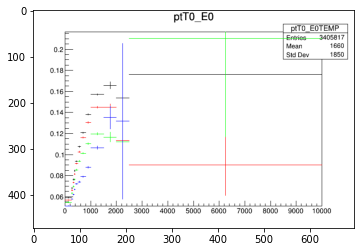

Info in <TCanvas::Print>: png file plots/Trate.png has been created


In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

RateHists=OrderedDict([])
canvrate=TCanvas("canvrate","canvrate",700,500)
color=1

alltoys=[]
for RH in LHists:
    print(RH)
    print(THists[RH].Integral())
    print(LHists[RH].Integral())
    
    RateHists["Rate"+RH]=copy.deepcopy(THists[RH])
    RateHists["Rate"+RH].Divide(RateHists["Rate"+RH],LHists[RH],1.0,1.0,"B")
    means = []
    errs = []
    toys = []
    for xbin in range(RateHists["Rate"+RH].GetXaxis().GetNbins()+1):
        means.append(RateHists["Rate"+RH].GetBinContent(xbin))
        errs.append(RateHists["Rate"+RH].GetBinError(xbin))
    curtoys=[]
    for tt in range(ntoys):
        curtoys.append(np.random.normal(means,errs))
    alltoys.append(curtoys)
    #print (curtoys)
    RateHists["Rate"+RH].SetLineColor(color)
    RateHists["Rate"+RH].SetMarkerColor(color)
    RateHists["Rate"+RH].Draw("same")
    color+=1
    
#for iiter in range(1000):
 #   for ijet in range(njet):
  #      for tth in THists:
   #         THists[tth]
    
canvrate.Print('plots/Trate.png', 'png')
imagerate = mpimg.imread('plots/Trate.png')
plt.imshow(imagerate)
plt.show()
evcont["RateHists"]=RateHists
evcont["toys"]=np.array(alltoys)

In [21]:
#Step1:use pass-to-fail ratio to predict background
proc = MakeProc(njet,1,evcont)
Mproc=PProcRunner(proc,nproc)
returndf=Mproc.Run()


len(hpass) 104


Dataset:TT Process:3:   0%|          | 0/4 [00:00<?, ?it/s]

Running process over 6 processors


Dataset:QCD_HT2000toInf Process:1: 100%|██████████| 4/4 [00:18<00:00,  4.72s/it]]


{'TT': ({}, {'Start': 6541390821.12743, 'File Read': 6541390821.325236, 'Parsed': 6541390823.043924, 'Analyzed': 6541390825.020695}, [100995, 10525]), 'QCD_HT1500to2000': ({}, {'Start': 11447434130.78029, 'File Read': 11447434131.636732, 'Parsed': 11447434149.672535, 'Analyzed': 11447434182.871532}, [1117337, 219031]), 'QCD_HT1000to1500': ({}, {'Start': 11447434533.612139, 'File Read': 11447434534.402668, 'Parsed': 11447434554.003288, 'Analyzed': 11447434580.523224}, [1134071, 161373]), 'QCD_HT2000toInf': ({}, {'Start': 6541391292.057017, 'File Read': 6541391292.326976, 'Parsed': 6541391298.276324, 'Analyzed': 6541391309.379986}, [365274, 73408])}


Dataset:QCD_HT2000toInf Process:0: 100%|██████████| 4/4 [00:43<00:00, 10.81s/it]]


{'TT': ({}, {'Start': 6541390821.693222, 'File Read': 6541390821.853688, 'Parsed': 6541390823.871624, 'Analyzed': 6541390825.861609}, [93718, 9789]), 'QCD_HT1500to2000': ({}, {'Start': 11447434117.354494, 'File Read': 11447434118.052223, 'Parsed': 11447434133.578548, 'Analyzed': 11447434160.059574}, [887521, 173811]), 'QCD_HT1000to1500': ({}, {'Start': 11447434486.500538, 'File Read': 11447434487.44855, 'Parsed': 11447434509.355007, 'Analyzed': 11447434539.674137}, [1421943, 203172]), 'QCD_HT2000toInf': ({}, {'Start': 6541391312.148719, 'File Read': 6541391312.733038, 'Parsed': 6541391326.855274, 'Analyzed': 6541391351.916872}, [938388, 189271])}


Dataset:QCD_HT2000toInf Process:2: 100%|██████████| 4/4 [00:23<00:00,  5.83s/it]]


{'TT': ({}, {'Start': 6541390819.307901, 'File Read': 6541390819.447198, 'Parsed': 6541390820.73628, 'Analyzed': 6541390822.384808}, [71022, 7584]), 'QCD_HT1500to2000': ({}, {'Start': 11447434192.718666, 'File Read': 11447434193.701067, 'Parsed': 11447434214.200401, 'Analyzed': 11447434252.380444}, [1299487, 253645]), 'QCD_HT1000to1500': ({}, {'Start': 11447434659.174013, 'File Read': 11447434660.357693, 'Parsed': 11447434686.160082, 'Analyzed': 11447434727.098064}, [1671298, 238687]), 'QCD_HT2000toInf': ({}, {'Start': 6541391413.246089, 'File Read': 6541391413.62032, 'Parsed': 6541391421.306316, 'Analyzed': 6541391435.157032}, [500780, 101033])}


Dataset:QCD_HT2000toInf Process:3: 100%|██████████| 4/4 [00:31<00:00,  8.00s/it]]


{'TT': ({}, {'Start': 6541390820.940357, 'File Read': 6541390821.104498, 'Parsed': 6541390822.800981, 'Analyzed': 6541390824.852209}, [100330, 10609]), 'QCD_HT1500to2000': ({}, {'Start': 11447434150.506382, 'File Read': 11447434151.833313, 'Parsed': 11447434178.13471, 'Analyzed': 11447434223.125776}, [1530208, 300112]), 'QCD_HT1000to1500': ({}, {'Start': 11447434787.174463, 'File Read': 11447434788.53434, 'Parsed': 11447434819.364113, 'Analyzed': 11447434864.75943}, [2053412, 293028]), 'QCD_HT2000toInf': ({}, {'Start': 6541391526.709994, 'File Read': 6541391527.210861, 'Parsed': 6541391537.551485, 'Analyzed': 6541391556.618581}, [741188, 149365])}


Dataset:QCD_HT2000toInf Process:5: 100%|██████████| 4/4 [00:56<00:00, 14.18s/it]


{'TT': ({}, {'Start': 4906043112.430475, 'File Read': 4906043112.58325, 'Parsed': 4906043113.574699, 'Analyzed': 4906043114.815728}, [59062, 6234]), 'QCD_HT1500to2000': ({}, {'Start': 11447434291.813093, 'File Read': 11447434293.440296, 'Parsed': 11447434326.729527, 'Analyzed': 11447434388.591301}, [2065403, 404623]), 'QCD_HT1000to1500': ({}, {'Start': 11447434992.177696, 'File Read': 11447434993.864458, 'Parsed': 11447435029.909504, 'Analyzed': 11447435082.160109}, [2657978, 379629]), 'QCD_HT2000toInf': ({}, {'Start': 6541391746.109266, 'File Read': 6541391747.020855, 'Parsed': 6541391764.59953, 'Analyzed': 6541391799.268205}, [1393455, 281409])}


Dataset:QCD_HT2000toInf Process:4: 100%|██████████| 4/4 [00:33<00:00,  8.49s/it]


{'TT': ({}, {'Start': 6541390820.901112, 'File Read': 6541390821.077507, 'Parsed': 6541390822.544452, 'Analyzed': 6541390824.257817}, [83357, 8637]), 'QCD_HT1500to2000': ({}, {'Start': 11447434437.860481, 'File Read': 11447434439.79922, 'Parsed': 11447434479.969503, 'Analyzed': 11447434559.603334}, [2748709, 537105]), 'QCD_HT1000to1500': ({}, {'Start': 11447435211.139374, 'File Read': 11447435213.158361, 'Parsed': 11447435250.83421, 'Analyzed': 11447435308.255987}, [2997294, 427466]), 'QCD_HT2000toInf': ({}, {'Start': 6541391802.909258, 'File Read': 6541391803.504974, 'Parsed': 6541391814.7061615, 'Analyzed': 6541391834.708519}, [842137, 169823])}
Done
0.0 3.8490282246566494
3.8490282246566494
0.0 3.849028311742586
3.849028311742586
0.0 14.3408789440291
14.3408789440291
0.0 0.0
0.0
0.0 3.8490283140272368
3.8490283140272368
0.0 12.41275194985792
12.41275194985792
0.0 0.0
0.0
0.0 3.8490280305268243
3.8490280305268243
0.0 7.156578196678311
7.156578196678311
0.0 0.0
0.0
0.0 110.12106194905

0.0
7797736.195344925 3721283.446609497
11519019.657997131
7767838.2116007805 3704688.7161712646
11472527.006268501
0.0 0.0
0.0
7746507.499031067 3691249.164126396
11437756.61953926
7767827.132944107 3704663.915380478
11472491.014875412
0.0 0.0
0.0
7765587.11332798 3704499.90930748
11470086.818209648
332.2605621616385 110.10175987512048
442.36232157077757
332.2623403364414 110.10232895922672
442.36466927287984
324.2062705999706 108.68462511803955
432.8908954614308
0.0 0.0
0.0
332.2622891892679 110.10229299517232
442.36458011117065
365.29890871886164 120.82014226005413
486.1190525016282
0.0 0.0
0.0
332.2624915172346 110.10241221962497
442.36490447970573
343.98630562983453 112.47790639288723
456.4642131589353
0.0 0.0
0.0
8814.328028355725 2919.2459425432608
11733.57393441815
8814.375194071326 2919.260799673386
11733.635966746137
6449.464944198728 2156.9010943472385
8606.36595968157
2219.4578467112733 734.4810848778579
2953.9389592661755
8814.375044881366 2919.260624472983
11733.635612105

In [22]:
histos=copy.deepcopy(proc.hists)
rebinval=1

htosum={}
htosum["QCD"]=["QCD_HT1500to2000","QCD_HT1000to1500","QCD_HT2000toInf"]

histdicts=[histos,ratehistos]
for hdict in histdicts:
        for curh in htosum:
            hdict[curh]={}
            for var in hdict[htosum[curh][0]]:
                for curhsum in htosum[curh]:
                        if  var in hdict[curh]:
                                hdict[curh][var].Add(hdict[curhsum][var])
                        else:
                                hdict[curh][var] = copy.deepcopy(hdict[curhsum][var])
                                hdict[curh][var].SetName(hdict[curhsum][var].GetName().replace(curhsum,curh))
                                hdict[curh][var].SetTitle(hdict[curhsum][var].GetName().replace(curhsum,curh))



TT


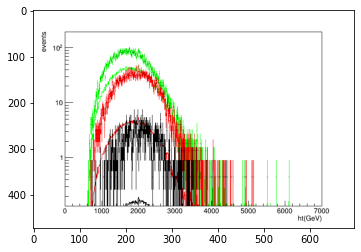

rat


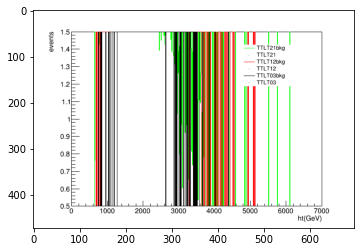

toys
QCD_HT1500to2000


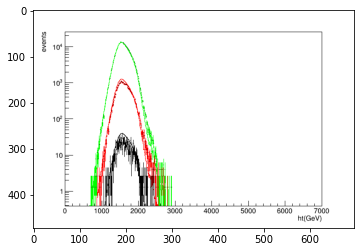

rat


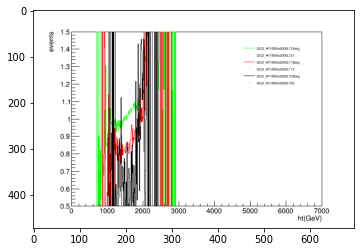

toys
QCD_HT1000to1500


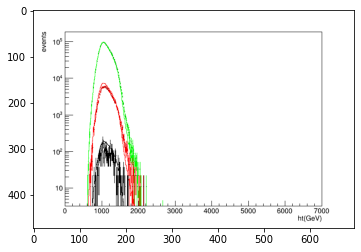

rat


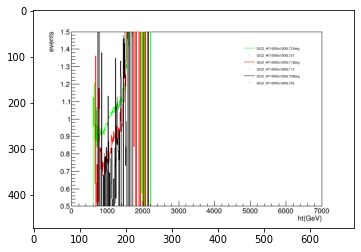

toys
QCD_HT2000toInf


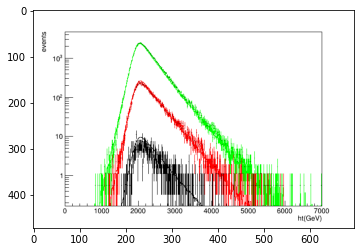

rat


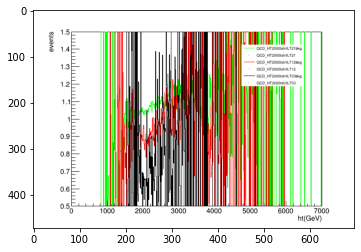

toys
QCD


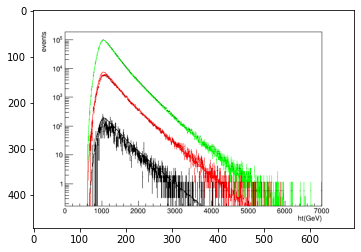

rat


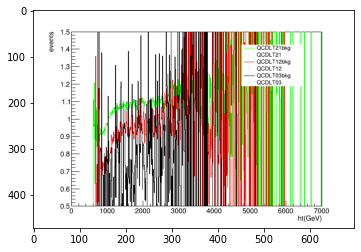

toys


Info in <TCanvas::Print>: png file plots/htTT.png has been created
Info in <TCanvas::SaveAs>: ROOT file plots/htTT.root has been created
Info in <TCanvas::Print>: png file plots/htratTT.png has been created
Info in <TCanvas::SaveAs>: ROOT file plots/htratTT.root has been created
Info in <TCanvas::Print>: png file plots/htQCD_HT1500to2000.png has been created
Info in <TCanvas::SaveAs>: ROOT file plots/htQCD_HT1500to2000.root has been created
Info in <TCanvas::Print>: png file plots/htratQCD_HT1500to2000.png has been created
Info in <TCanvas::SaveAs>: ROOT file plots/htratQCD_HT1500to2000.root has been created
Info in <TCanvas::Print>: png file plots/htQCD_HT1000to1500.png has been created
Info in <TCanvas::SaveAs>: ROOT file plots/htQCD_HT1000to1500.root has been created
Info in <TCanvas::Print>: png file plots/htratQCD_HT1000to1500.png has been created
Info in <TCanvas::SaveAs>: ROOT file plots/htratQCD_HT1000to1500.root has been created
Info in <TCanvas::Print>: png file plots/htQCD_H

In [23]:
#Plot ht
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
output = TFile("FromFlatPandas_AE"+op_aeval+"_M"+op_massrange+"_Njet"+str(op_njet)+".root","recreate")
output.cd()

for RHtext in RateHists:
 
    RateHists[RHtext].Write("TRate"+RH)

for ds in ratehistos:
    for var in ratehistos[ds]:
            ratehistos[ds][var].Write(ds+"__"+var)

if ntoys>0:
    for ds in histos:

        canvtoys=TCanvas("httoys"+ds,"httoys"+ds,700,500)
        canvtoyspread=TCanvas("httoyspread"+ds,"httoyspread"+ds,700,500)

        histoiter=list(range(njet+1))
        histoiter.reverse()
        histoiter.pop(0)    
        for ijet in histoiter:
                regionstr="LT"+str(ijet)+str(njet-ijet)

                bkgname="bkg_ht_"+regionstr

                dataname="ht_"+regionstr
                canvtoys.cd()
                bindists=[]

                for itoy in  range(ntoys):
                    bindists.append([])
                    for xbin in range(histos[ds]["bkg_ht_toy"+str(itoy)+"_"+regionstr].GetXaxis().GetNbins()):
                        bindists[-1].append(histos[ds]["bkg_ht_toy"+str(itoy)+"_"+regionstr].GetBinContent(xbin))
                    if itoy==0:
                        histos[ds]["bkg_ht_toy"+str(itoy)+"_"+regionstr].Draw("hist")  
                    else:
                        histos[ds]["bkg_ht_toy"+str(itoy)+"_"+regionstr].Draw("samehist") 
                histos[ds]["bkg_ht_"+regionstr].Draw("same") 
                binarr=np.array(bindists)
                totoy=binarr.shape[0]
                totbins=binarr.shape[1]
                histos[ds]["bkg_ht_toyspread_"+regionstr]=copy.deepcopy(histos[ds][bkgname])
                histos[ds]["bkg_ht_toyspread_"+regionstr].SetName("bkg_ht_toyspread_"+regionstr)
                histos[ds]["bkg_ht_toyspread_"+regionstr].SetTitle("bkg_ht_toyspread_"+regionstr)
                for ibin in range(totbins):
                    #print(binarr[:,ibin].std())
                    histos[ds]["bkg_ht_toyspread_"+regionstr].SetBinContent(ibin,binarr[:,ibin].mean())
                    histos[ds]["bkg_ht_toyspread_"+regionstr].SetBinError(ibin,binarr[:,ibin].std())
                canvtoyspread.cd()
                histos[ds]["bkg_ht_toyspread_"+regionstr].Draw("same")
    canvtoys.Write()    
    canvtoys.Print('plots/httoys'+ds+'.png', 'png')  
    canvtoys.Print('plots/httoys'+ds+'.root', 'root')  
    image = mpimg.imread('plots/httoys'+ds+'.png')
    plt.imshow(image)
    plt.show()
    print("toys")    

for ds in histos:
    for var in histos[ds]:
            histos[ds][var].Write(ds+"__"+var)
            #print(ds,var,histos[ds][var].Integral())
    #print(histos[ds])
    canv=TCanvas("ht"+ds,"ht"+ds,700,500)
    canvrat=TCanvas("htrat"+ds,"htrat"+ds,700,500)
    gPad.SetLeftMargin(0.12)
    leg = TLegend(0.65, 0.65, 0.84, 0.84)
    leg.SetFillColor(0)
    leg.SetBorderSize(0)
    histoiter=list(range(njet+1))
    histoiter.reverse()
    histoiter.pop(0)
    allrat=[]

    for ijet in histoiter:
            regionstr="LT"+str(ijet)+str(njet-ijet)

            bkgname="bkg_ht_"+regionstr
            dataname="ht_"+regionstr
            color=ijet+1


            ratehistos[ds][dataname].SetLineColor(color)
            ratehistos[ds][dataname].SetTitle(";ht(GeV);events")
            ratehistos[ds][dataname].SetStats(0) 
            ratehistos[ds][dataname].Rebin(rebinval) 

            histos[ds][bkgname].SetLineColor(color)
            histos[ds][bkgname].Rebin(rebinval) 
            
            canv.cd()
            ratehistos[ds][dataname].Draw("same")   
            histos[ds][bkgname].Draw("histsame") 
            
            
            leg.AddEntry(histos[ds][bkgname],ds+regionstr+"bkg","L")
            leg.AddEntry(ratehistos[ds][dataname],ds+regionstr,"P")

            canvrat.cd()
            allrat.append(copy.deepcopy(ratehistos[ds][dataname]) )
            allrat[-1].Divide(histos[ds][bkgname])
            allrat[-1].GetYaxis().SetRangeUser(0.5,1.5)
            allrat[-1].Draw("histsame") 
  

    leg.Draw()
    canv.SetLogy()
    canv.Write()
    canv.Print('plots/ht'+ds+'.png', 'png')
    canv.Print('plots/ht'+ds+'.root', 'root')
    print(ds)
    
    canvrat.Write()    
    canvrat.Print('plots/htrat'+ds+'.png', 'png') 
    canvrat.Print('plots/htrat'+ds+'.root', 'root')  

    image = mpimg.imread('plots/ht'+ds+'.png')

    plt.imshow(image)
    plt.show()
    print("rat")

    image = mpimg.imread('plots/htrat'+ds+'.png')
    plt.imshow(image)
    plt.show()
    print("toys")


    
    
    
output.Close()